# Measure skew-spectra of DM in redshift space --version 2#

In [1]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d

plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [2]:
theo_basedir = '../data/azadeh_08sep2020/'
Rsmooth = 20.

# z=0 to z=0.6 in ms_gadget cosmology
z_rescalefac = 0.7336055475

## Read and plot Azadeh theory ##

In [3]:
Ptheo = np.genfromtxt(os.path.join(theo_basedir, 'p_deltadelta.txt'), names=True)

In [4]:
Ptheo.dtype

dtype([('k', '<f8'), ('P_link', '<f8'), ('P_0k', '<f8'), ('P_2k', '<f8'), ('P_4k', '<f8')])

In [5]:
realnames = ['k'] + ['S%dp_lin' %d for d in range(1,15)]
Sn_real_theo = np.genfromtxt(os.path.join(theo_basedir, 'Sn_real_R%d.txt' % int(Rsmooth)), names=realnames)
Sn_rsd_theo = OrderedDict()
for ell in [0,2,4]:
    rsdnames = ['k'] + ['S%d' % d for d in range(1,15)]
    Sn_rsd_theo[(ell,)] = np.genfromtxt(os.path.join(theo_basedir, 'Sn_rsd_%d_R%d.txt' % (ell,int(Rsmooth))), names=rsdnames)
    print(Sn_rsd_theo[(ell,)].dtype.names)

('k', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14')
('k', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14')
('k', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14')


In [6]:
print(Sn_real_theo.dtype.names)

('k', 'S1p_lin', 'S2p_lin', 'S3p_lin', 'S4p_lin', 'S5p_lin', 'S6p_lin', 'S7p_lin', 'S8p_lin', 'S9p_lin', 'S10p_lin', 'S11p_lin', 'S12p_lin', 'S13p_lin', 'S14p_lin')


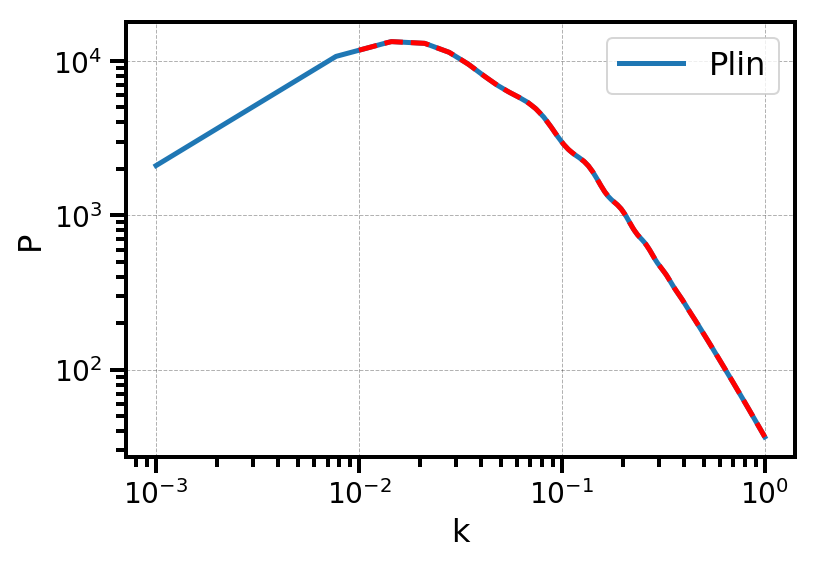

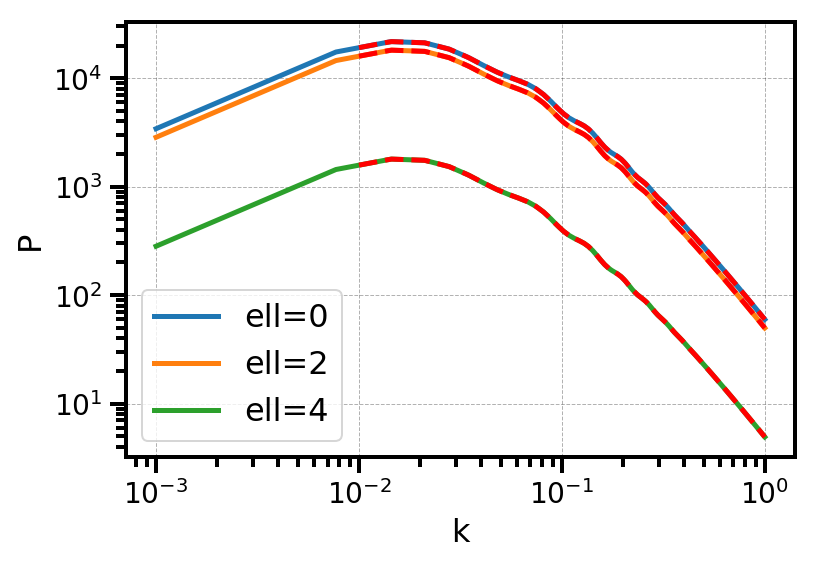

In [7]:
# plot Plin azadeh
# interp_lnPtheo_lnk = OrderedDict()
# interp_Ptheo_k = OrderedDict()
# for key in Ptheo.dtype.names:
#     if key == 'k':
#         continue
#     interp_lnPtheo_lnk[key] = interp1d(np.log(Ptheo['k']), np.log(Ptheo[key]))
#     interp_Ptheo_k[key] = lambda k: np.exp(interp_lnPtheo_lnk[key](np.log(k)))
    
interp_lnPtheo_lnk_Plin = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_link']))
interp_Ptheo_k_Plin = lambda k: np.exp(interp_lnPtheo_lnk_Plin(np.log(k)))
interp_lnPtheo_lnk_P0 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_0k']))
interp_Ptheo_k_P0 = lambda k: np.exp(interp_lnPtheo_lnk_P0(np.log(k)))
interp_lnPtheo_lnk_P2 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_2k']))
interp_Ptheo_k_P2 = lambda k: np.exp(interp_lnPtheo_lnk_P2(np.log(k)))
interp_lnPtheo_lnk_P4 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_4k']))
interp_Ptheo_k_P4 = lambda k: np.exp(interp_lnPtheo_lnk_P4(np.log(k)))


# plot Plin
plt.subplots(figsize=(6,4))
plt.loglog(Ptheo['k'], Ptheo['P_link'], label='Plin')
kvec = np.logspace(-2,0,100)
plt.loglog(kvec, interp_Ptheo_k_Plin(kvec), 'r--')
plt.legend();
plt.ylabel('P'); plt.xlabel('k');

# Plot multipole power spectra azadeh
plt.subplots(figsize=(6,4))
for ell in [0,2,4]:
    plt.loglog(Ptheo['k'], Ptheo['k']**0*Ptheo['P_%dk' % ell], label='ell=%d'%ell)
    if ell==0:
        plt.loglog(kvec, interp_Ptheo_k_P0(kvec), 'r--')
    elif ell==2:
        plt.loglog(kvec, interp_Ptheo_k_P2(kvec), 'r--')
    elif ell==4:
        plt.loglog(kvec, interp_Ptheo_k_P4(kvec), 'r--')
plt.legend();
plt.ylabel('P'); plt.xlabel('k');




In [8]:
# PLot real space theory S_n from azadeh
if False:
    fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
    for counter, n in enumerate(range(1,15)):
        ax = axarr[counter%7,counter//7]
        ax.semilogx(Sn_real_theo['k'], Sn_real_theo['S%dp_lin'%n])
        ax.set_ylabel(r'$S^\mathregular{real}_{%d}/P_\mathregular{lin}$' % n)
    axarr[6,0].set_xlabel('k')
    axarr[6,1].set_xlabel('k')
    plt.tight_layout()

In [9]:
# PLot RSD theory S_n from azadeh
if False:
    fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
    for counter, n in enumerate(range(1,15)):
        ax = axarr[counter%7,counter//7]
        for ell in [0,2]:
            ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)]['S%d'%n], label=r'$\ell=%d$'%ell)
        ax.set_ylabel(r'$S^{(\ell)}_{%d}/P_\ell$' % n)
        ax.legend(loc='best')
    axarr[6,0].set_xlabel('k')
    axarr[6,1].set_xlabel('k')
    plt.tight_layout()

## Calculate power spectrum multipoles ##

In [10]:
if False:
    # plot power spectrum of density
    plt.figure(figsize=(8,6))
    kvec = Pdd.poles['k']
    kpow = 1

    for counter, ell in enumerate(Pdd.attrs['poles']):
        if ell>2:
            lw, alpha = 1,0.4
        else:
            lw, alpha = 3,1
        color = colors[counter]
        plt.semilogx(kvec, (kvec**kpow*Pdd.poles['power_%d'%ell].real), label=r'$\ell=%d$'%ell,
                lw=lw, alpha=alpha, color=color)
        plt.semilogx(Ptheo['k'], Ptheo['k']**kpow*Ptheo['P_%dk' % ell], label='azadeh', color=color, ls='--', lw=lw, alpha=alpha)

    plt.xlabel(r'$k$')
    ax = plt.gca()
    ax.set_xlim((0.01,1))
    ax.legend(loc='best', ncol=1, fontsize=12)
    ax.set_ylabel(r'$k^%dP_\ell[\delta,\delta]$' % kpow)
    plt.tight_layout()
    if kpow == 1:
        plt.ylim((-500,800));
    else:
        plt.ylim((-500,20000));
    


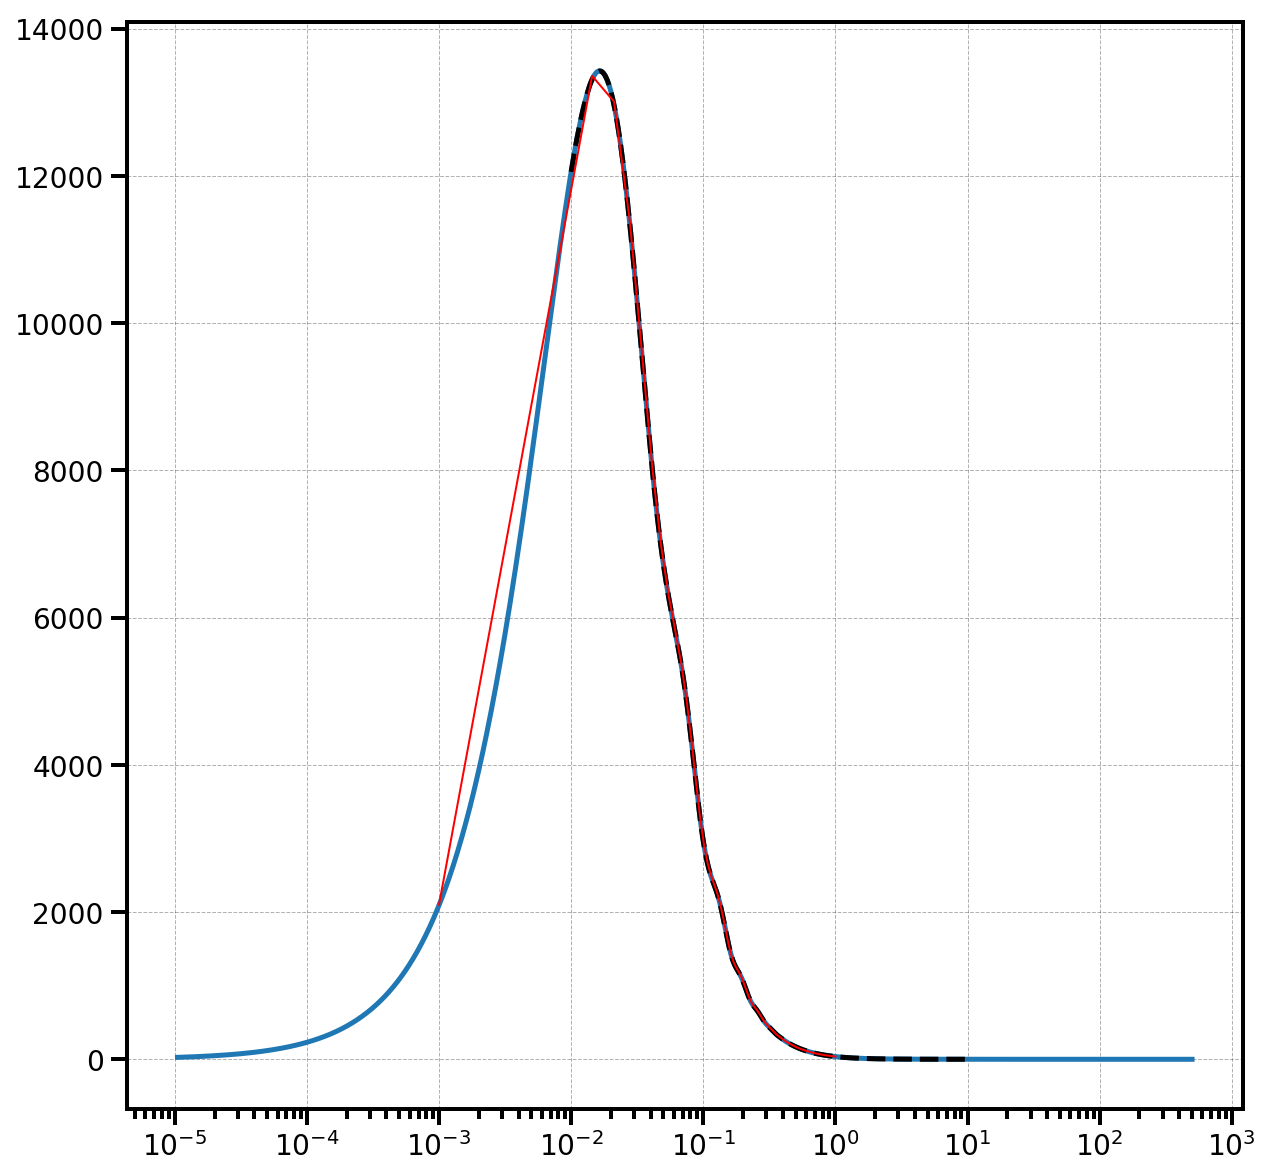

In [11]:
# Get linear power spectrum and plot
# read Plinear at z=0
Plin_z0 = np.genfromtxt('../data/planck_camb_56106182_matterpower_z0.dat')
# convert to z=0.6
Plin = Plin_z0
Plin[:,1] *= z_rescalefac**2


interp_lnPlin_lnk = interp1d(np.log(Plin[:,0]), np.log(Plin[:,1]))
interp_Plin_k = lambda k: np.exp(interp_lnPlin_lnk(np.log(k)))

plt.subplots(figsize=(10,10))
plt.loglog(Plin[:,0], Plin[:,1])
tmpk = np.logspace(-2,1,200)
plt.loglog(tmpk, interp_Plin_k(tmpk), 'k--')

# also azadeh Plin
plt.semilogx(Ptheo['k'], Ptheo['P_link'], 'r-', lw=1)
ax = plt.gca()
ax.set_yscale('linear')

In [12]:
if False:
    # compare density power vs linear theory
    plt.figure(figsize=(8,6))
    kvec = Pdd.poles['k']

    if APPLY_RSD:
        plt.semilogx(kvec, Pdd.poles['power_%d'%0].real / ((1. + 2.*f_log_growth/3. + f_log_growth**2/5.)*interp_Plin_k(kvec)),
                     label=r'$\ell=%d$'%0)
        plt.ylabel(r'$P_\ell[\delta,\delta]/P^\mathregular{RSD}_\mathregular{lin}$')
    else:
        plt.semilogx(kvec, Pdd.poles['power_%d'%0].real / interp_Plin_k(kvec),
                     label=r'$\ell=%d$'%0)
        plt.ylabel(r'$P_\ell[\delta,\delta]/P_\mathregular{lin}$')

    plt.xlabel(r'$k$')
    ax = plt.gca()
    ax.set_xlim((0.01,1))
    ax.legend(loc='best', ncol=2, fontsize=12)
    ax.set_ylim((0.5,1.5))
    plt.tight_layout()

## Read all RSD skew spectra from disk ##

In [35]:
# read options
sim_seeds = range(400,406)
boxsize = 1500.
Ngrid = 512
APPLY_RSD = 0
poles = [0,2]

In [36]:
# read files
import os
from collections import OrderedDict

Nsims = len(sim_seeds)
Sn = {'power_%d' % ell: None for ell in poles}
skew_spectra = ['S%d'%d for d in range(1,15)]

for isim, sim_seed in enumerate(sim_seeds):
    for ell in [0,2]:
        Pskew_sims_dir = '../data/Pskew_sims/00000%d-01536-%.1f-wig/R%.1f_Ng%d_RSD%d/' % (
            sim_seed, boxsize, Rsmooth, Ngrid,
            int(APPLY_RSD))
        fname = os.path.join(Pskew_sims_dir, 'Sn_ell%d.txt'%ell)
        print('Read %s' % fname)
        
        if Sn['power_%d'%ell] is None:
            # get shape
            tmp = np.genfromtxt(fname, names=['k']+skew_spectra)
            Nk = tmp.shape[0]
            Sn['power_%d'%ell] = OrderedDict()
            for key in tmp.dtype.names:
                Sn['power_%d'%ell][key] = np.zeros((Nsims, Nk)) + np.nan
            
        tmp = np.genfromtxt(fname, names=['k']+skew_spectra)
        for key in tmp.dtype.names:
            Sn['power_%d'%ell][key][isim,:] = tmp[key]

Read ../data/Pskew_sims/00000400-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell0.txt
Read ../data/Pskew_sims/00000400-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell2.txt
Read ../data/Pskew_sims/00000401-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell0.txt
Read ../data/Pskew_sims/00000401-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell2.txt
Read ../data/Pskew_sims/00000402-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell0.txt
Read ../data/Pskew_sims/00000402-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell2.txt
Read ../data/Pskew_sims/00000403-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell0.txt
Read ../data/Pskew_sims/00000403-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell2.txt
Read ../data/Pskew_sims/00000404-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell0.txt
Read ../data/Pskew_sims/00000404-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell2.txt
Read ../data/Pskew_sims/00000405-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell0.txt
Read ../data/Pskew_sims/00000405-01536-1500.0-wig/R20.0_Ng512_RSD0/Sn_ell2.txt


Made ../pdf/skewV2_DM_L1500_R20.0_Ng512_RSD0.pdf


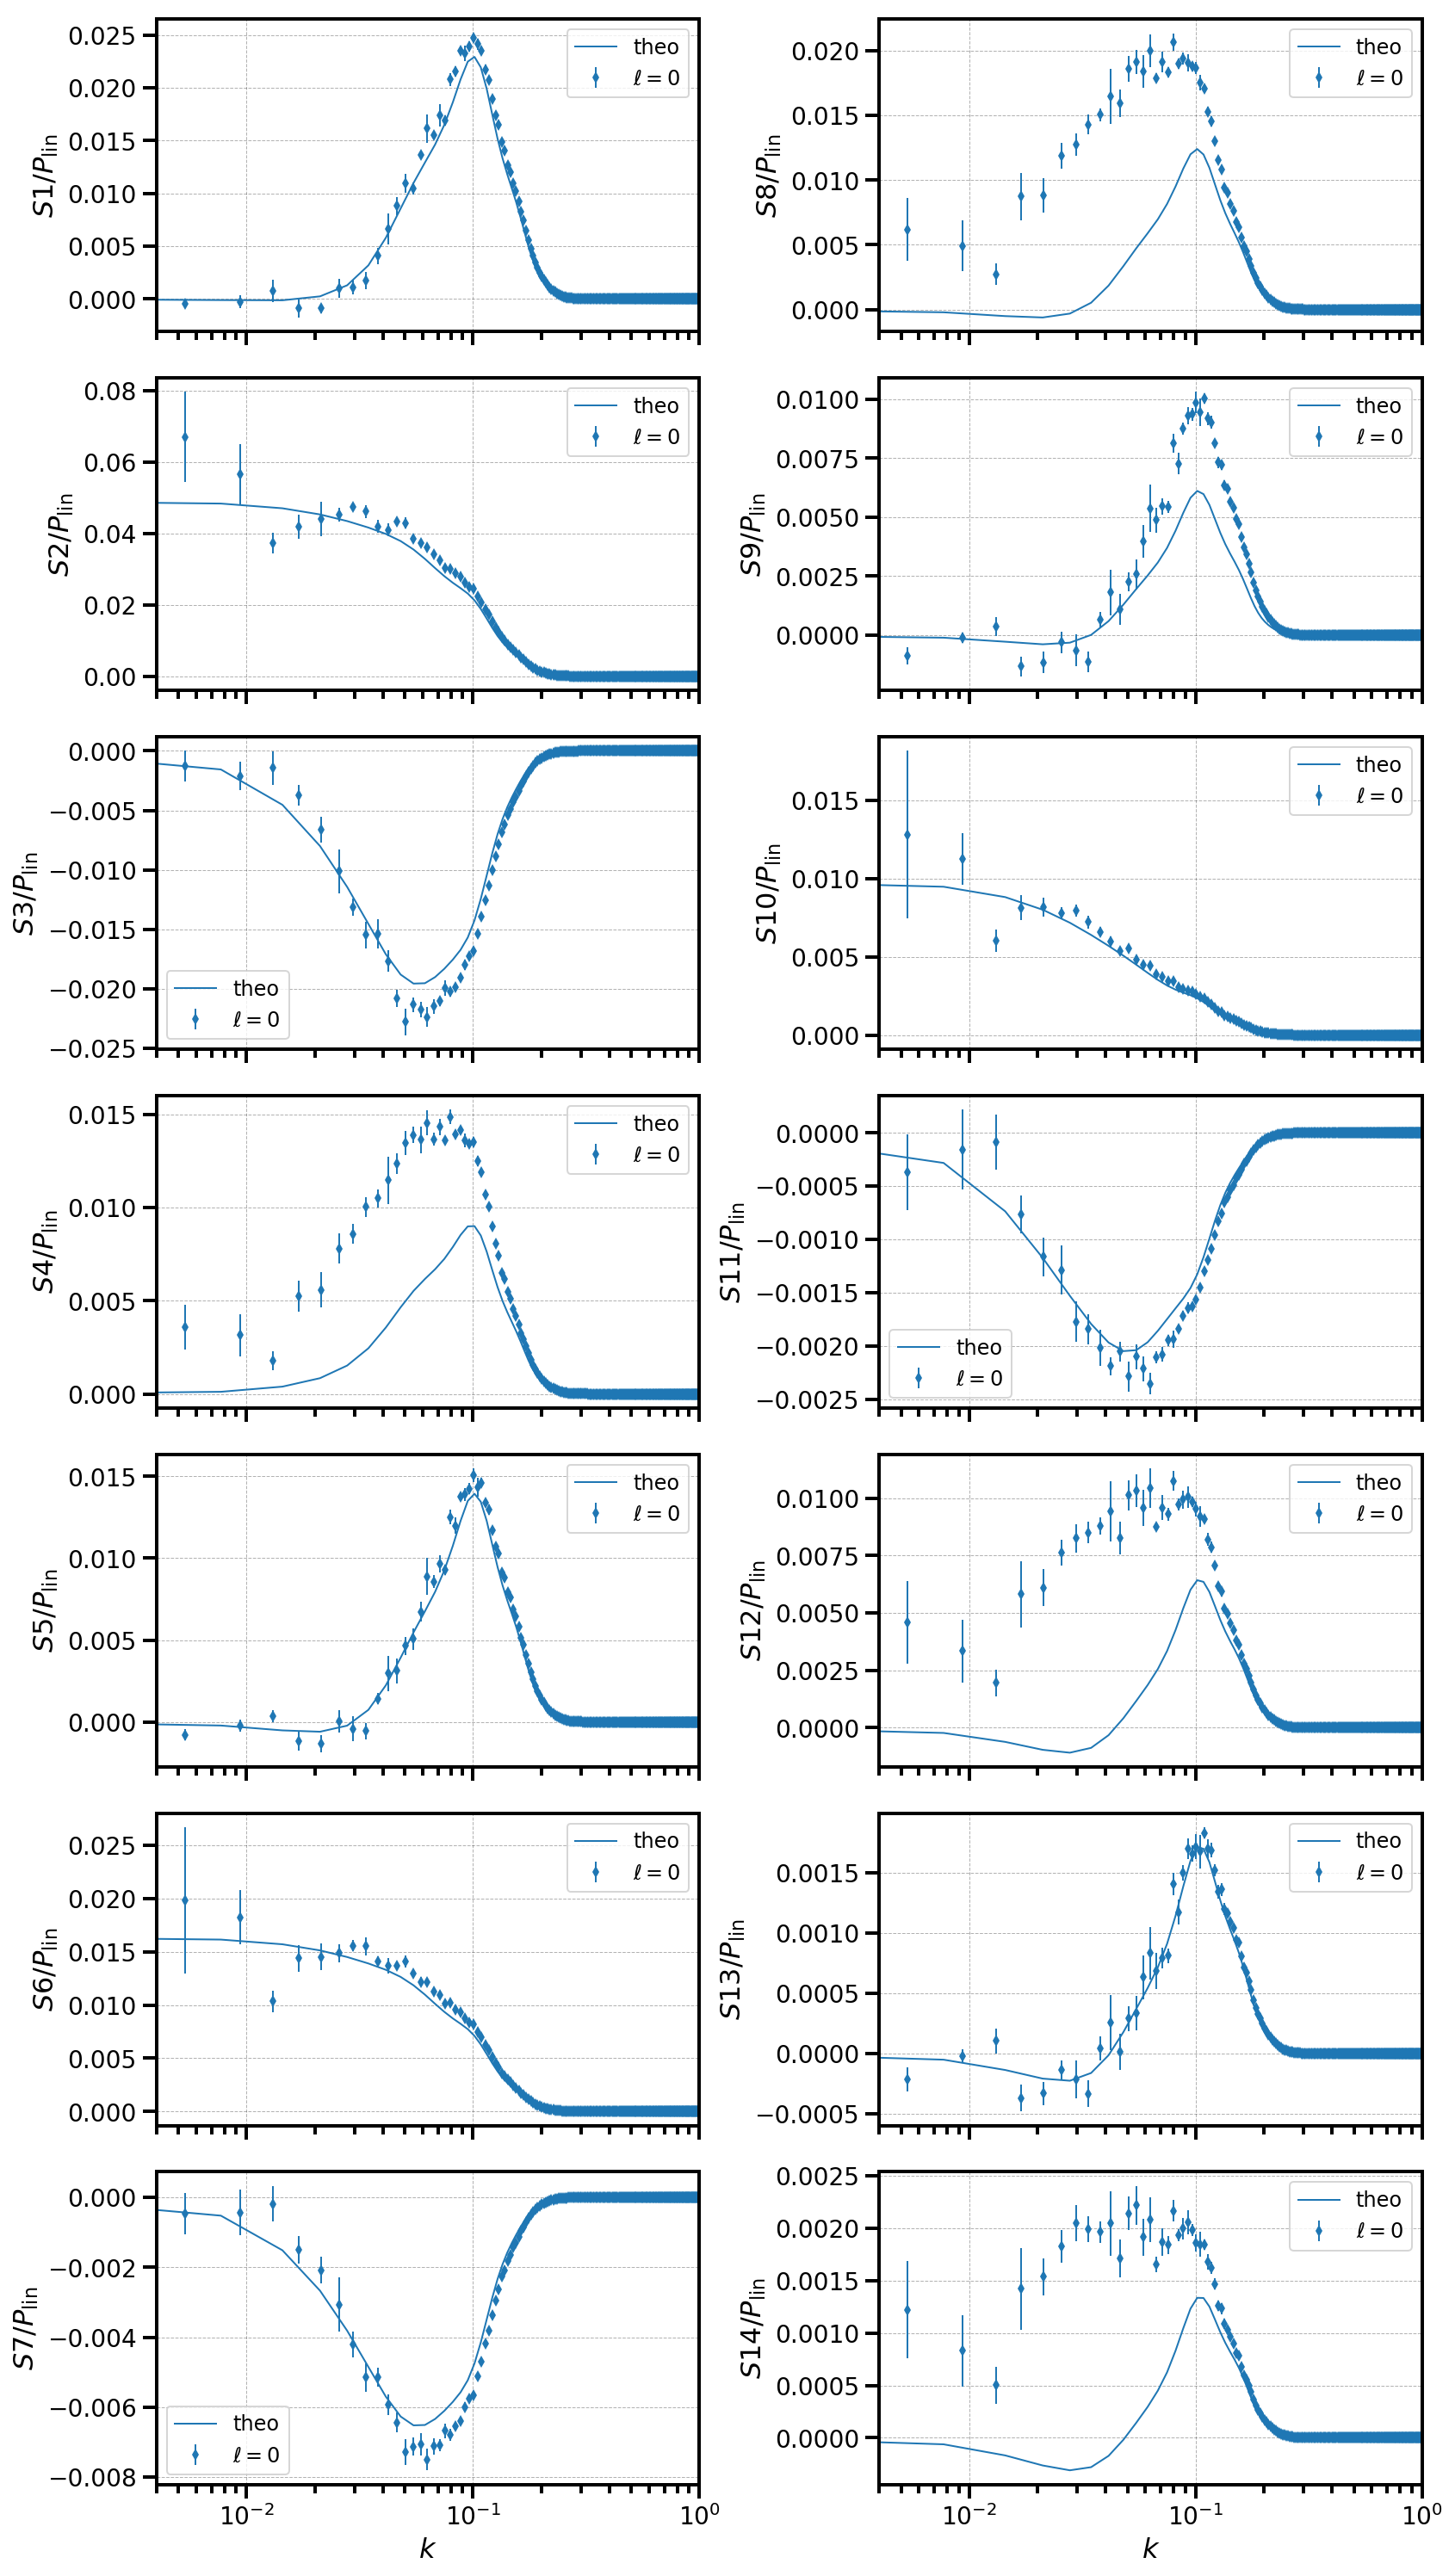

In [43]:
# plot Pskew/P_dd
fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)

for ell in [0]:        
    color = colors[ell]

    kvec = np.mean(Sn['power_%d'%ell]['k'], axis=0)
    ww = np.where(kvec<=1.0)[0]

    for counter, skew_spec in enumerate(skew_spectra[:]):
        ax = axarr[counter%7,counter//7]

        # plot measurements
        if APPLY_RSD:
            if False:
                # divide by measured P_l
                ax.semilogx(kvec[ww], skew_spec.Pskew.poles['power_%d'%ell].real[ww]/Pdd.poles['power_%d'%ell].real[ww], marker='o', lw=0,
                             label=r'$\ell=%d$'%ell, color=color, markersize=5)

        # divide by theory P_l
        if APPLY_RSD:
            if ell==0:
                denomi = interp_Ptheo_k_P0(kvec[ww])
            elif ell==2:
                demomi = interp_Ptheo_k_P2(kvec[ww])
            else:
                denomi = np.nan
        else:
            denomi = interp_Ptheo_k_Plin(kvec[ww])
        ymat = Sn['power_%d'%ell][skew_spec][:,ww]
        ax.errorbar(kvec[ww], 
                    np.mean(ymat, axis=0)/denomi,
                    yerr=np.std(ymat, axis=0)/denomi/np.sqrt(float(Nsims)), elinewidth=1,
                    marker='d', lw=0, color=color,
                     label=r'$\ell=%d$'%ell, markersize=5)

        # plot theory skew spectra 
        if APPLY_RSD:
            # S_n/Pl
            if skew_spec in Sn_rsd_theo[(ell,)].dtype.names:
                ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)][skew_spec], label='theo', color=color,
                    lw=1)
        else:
            # S_n/Plin
            if skew_spec+'p_lin' in Sn_real_theo.dtype.names:
                ax.semilogx(Sn_real_theo['k'], Sn_real_theo[skew_spec+'p_lin'], label='theo', color=color,
                    lw=1)

        # cosmetics
        ax.set_xlim((0.004,1))
        ax.legend(loc='best', ncol=1, fontsize=12)
        if APPLY_RSD:
            ax.set_ylabel(r'$%s/P^\ell_{\delta\delta}$' % skew_spec)
        else:
            ax.set_ylabel(r'$%s/P_\mathregular{lin}$' % skew_spec)
axarr[6,0].set_xlabel(r'$k$')
axarr[6,1].set_xlabel(r'$k$')
plt.tight_layout()

fname = '../pdf/skewV2_DM_L%g_R%.1f_Ng%d_RSD%d.pdf' % (boxsize, Rsmooth,Ngrid,int(APPLY_RSD))
plt.savefig(fname)
print('Made %s' % fname)

In [ ]:
2.*np.pi/1500.

In [ ]:
str(skew_spec.Pskew.attrs)